Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.4339 - val_loss: 0.3041
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2194 - val_loss: 0.1920
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2741 - val_loss: 0.1518
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1570 - val_loss: 0.1217
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1390 - val_loss: 0.1243
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1756 - val_loss: 0.1067
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0856 - val_loss: 0.1461
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1076 - val_loss: 0.1146
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0916 - val_loss: 0.1079
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0859 - val_loss: 0.1208
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0574 - val_loss: 0.1192
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


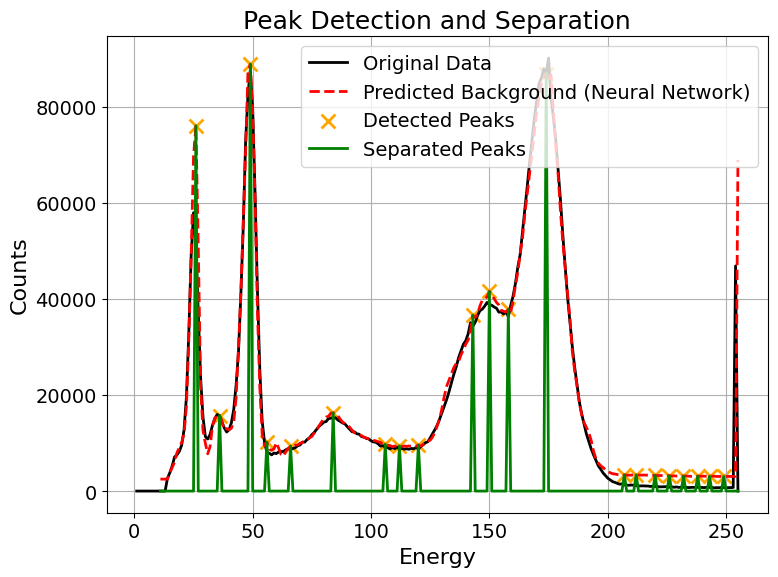

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks

# Load the data
data = pd.read_csv('15.5.csv')
energy = data.iloc[:, 0].values
counts = data.iloc[:, 1].values

# Normalize the data
scaler = StandardScaler()
counts_scaled = scaler.fit_transform(counts.reshape(-1, 1)).flatten()

# Prepare the data for the model
def create_dataset(data, window_size=10):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])  # Target is the next value
    return np.array(X), np.array(y)

window_size = 10  # Reduced window size for better peak detection
X, y = create_dataset(counts_scaled, window_size)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network model
model = Sequential()
model.add(Input(shape=(window_size,)))
model.add(Dense(128, activation='relu'))  # Increased number of nodes
model.add(Dropout(0.2))  # Added Dropout to prevent overfitting
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1)

# Predict the data
y_pred = model.predict(X)

# Rescale the predicted data
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Detect peaks with optimized parameters
def detect_peaks(signal, height=None, distance=5, prominence=0.3):
    peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)
    return peaks

# Detect peaks in the corrected signal
peaks = detect_peaks(y_pred_rescaled.flatten(), height=0, distance=5, prominence=0.3)

# Separate the peaks from the signal
peak_signal = np.zeros_like(y_pred_rescaled.flatten())
peak_signal[peaks] = y_pred_rescaled.flatten()[peaks]

# Visual settings
plt.rcParams.update({'font.size': 14, 'lines.linewidth': 2, 'axes.grid': True})

# Plot the results in a single chart
plt.figure(figsize=(8, 6))

# Original data and detected peaks
plt.plot(energy, counts, label='Original Data', color='black', linewidth=2)
plt.plot(energy[window_size:], y_pred_rescaled.flatten(), label='Predicted Background (Neural Network)', color='red', linestyle='--', linewidth=2)
plt.scatter(energy[window_size:][peaks], y_pred_rescaled.flatten()[peaks], color='orange', marker='x', s=100, label='Detected Peaks')
plt.plot(energy[window_size:], peak_signal, label='Separated Peaks', color='green', linestyle='-', linewidth=2)

# Final settings for the plot
plt.legend()
plt.xlabel('Energy', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.title('Peak Detection and Separation', fontsize=18)

plt.tight_layout()
plt.show()
